# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.109943,True,7.305573
1,2.705252,True,8.099747
2,1.097364,False,0.618054
3,0.270309,True,5.591181
4,0.792076,True,6.566470
...,...,...,...
995,1.613902,True,6.323625
996,2.075258,True,6.477758
997,0.731176,True,6.368071
998,2.685021,True,8.476229


<AxesSubplot:xlabel='v0'>

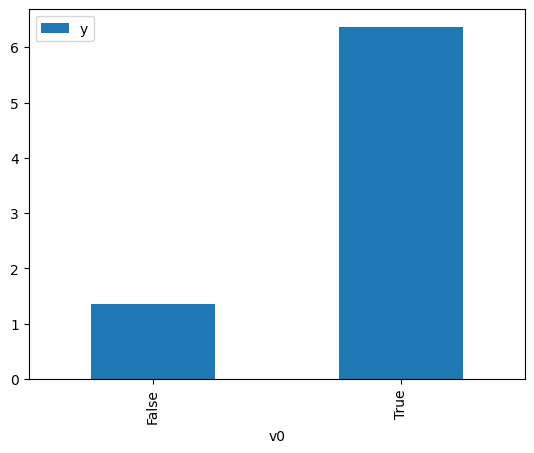

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

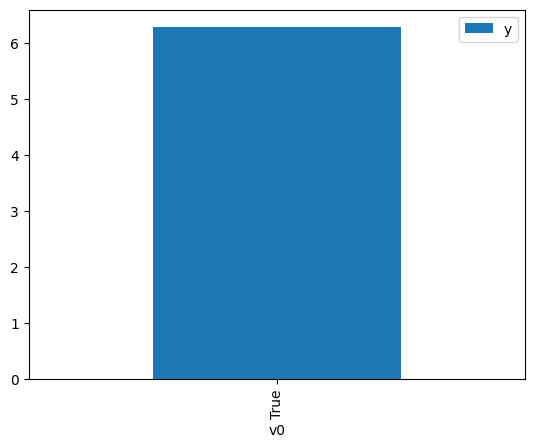

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.465805,False,0.681638,0.295449,3.384674
1,1.380222,False,1.067696,0.073165,13.667814
2,0.525696,False,2.362515,0.273201,3.660307
3,2.242716,False,2.756181,0.016076,62.205619
4,-0.132358,False,0.667550,0.555610,1.799823
...,...,...,...,...,...
995,0.734039,False,1.406573,0.204413,4.892056
996,1.501630,False,1.230339,0.059480,16.812366
997,0.228203,False,1.128085,0.392902,2.545163
998,2.047324,False,2.413841,0.022812,43.836657


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.183828,True,6.385451,0.587608,1.701814
1,-0.819853,True,4.395469,0.185588,5.388283
2,0.838557,True,6.368579,0.824888,1.212286
3,1.819416,True,6.528172,0.965814,1.035396
4,1.245936,True,6.679730,0.908364,1.100881
...,...,...,...,...,...
995,-0.310125,True,5.876104,0.366324,2.729827
996,0.044863,True,5.820469,0.525053,1.904571
997,-0.263780,True,4.675442,0.386184,2.589438
998,0.561118,True,6.408892,0.739454,1.352349


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          1.760e+04
Date:                Thu, 01 Sep 2022   Prob (F-statistic):                        0.00
Time:                        18:33:54   Log-Likelihood:                         -1396.9
No. Observations:                1000   AIC:                                      2798.
Df Residuals:                     998   BIC:                                      2808.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.3620      0.038     36.106      0.000       1.288       1.436
x2             5.1017      0.056     90.628      0.000       4.991       5.212
==============================================================================
Omnibus:                        1.422   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                1.345
Skew:                          -0.001   Prob(JB):                        0.510
Kurtosis:                       3.180   Cond. No.                         3.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""